# Backpropagation for Neural Networks

The goal of this practical session is to implement a (very) simple Neural Network in `Numpy`, using backpropagation (aka the chain rule).

### Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

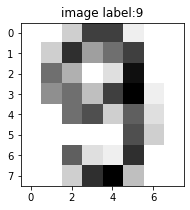

In [2]:
sample_index = np.random.randint(0,digits.images.shape[0])
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label:"+str(digits.target[sample_index]))
plt.show()

### Preprocessing

- Normalization
- Train / test split

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)

# mean = 0 and standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 1. Numpy Implementation

### a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
$$y = softmax(\mathbf{W} x + b)$$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


#### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

Implement the softmax function so that it works for both an individual vector of activations and a batch of activation vectors:

In [7]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

print("Softmax of a single vector:")
print(softmax([10, 2, -3]))
print('')

print("Sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

Softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]

Sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Implement a function that given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred` returns the negative log likelihood. Make sure that your implementation can compute the average negative log likelihood of a group of predictions `Y_pred` and `Y_true`, and can therefore be past as 2D arrays:

In [8]:
EPSILON = 1e-8
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

Check that the average NLL of the following 3 almost perfect:

In [9]:
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0033501019174971905


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [10]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size), low=-0.1, high=0.1)
        self.b = np.random.uniform(size=output_size, low=-0.1, high=0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Build an untrained model and test its forward inference:

In [11]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.3683, train acc: 0.119, test acc: 0.087


Evaluate the randomly initialized model on the first example:

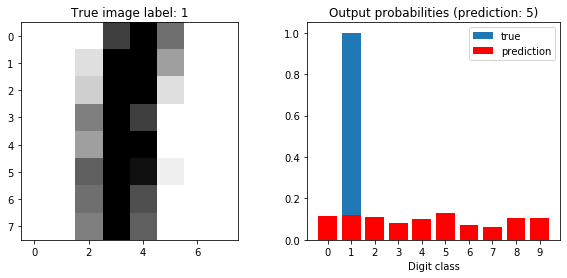

In [12]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [13]:
# Training for one epoch
learning_rate = 0.01
N_epochs = 10

for epoch in range(N_epochs):
    print('--- Epoch', epoch+1, '/', N_epochs ,'---')
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        lr.train(x, y, learning_rate)
        if i % 300 == 0:
            train_loss = lr.loss(X_train, y_train)
            train_acc = lr.accuracy(X_train, y_train)
            test_acc = lr.accuracy(X_test, y_test)
            print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (i, train_loss, train_acc, test_acc))

--- Epoch 1 / 10 ---
Update #0, train loss: 2.3507, train acc: 0.117, test acc: 0.082
Update #300, train loss: 0.6136, train acc: 0.902, test acc: 0.884
Update #600, train loss: 0.3948, train acc: 0.934, test acc: 0.942
Update #900, train loss: 0.3052, train acc: 0.941, test acc: 0.940
Update #1200, train loss: 0.2583, train acc: 0.947, test acc: 0.933
--- Epoch 2 / 10 ---
Update #0, train loss: 0.2450, train acc: 0.949, test acc: 0.940
Update #300, train loss: 0.2191, train acc: 0.958, test acc: 0.949
Update #600, train loss: 0.1996, train acc: 0.964, test acc: 0.953
Update #900, train loss: 0.1845, train acc: 0.966, test acc: 0.951
Update #1200, train loss: 0.1713, train acc: 0.973, test acc: 0.953
--- Epoch 3 / 10 ---
Update #0, train loss: 0.1683, train acc: 0.968, test acc: 0.958
Update #300, train loss: 0.1579, train acc: 0.970, test acc: 0.958
Update #600, train loss: 0.1506, train acc: 0.975, test acc: 0.953
Update #900, train loss: 0.1435, train acc: 0.976, test acc: 0.953
Upd

Evaluate the trained model on a random test example:

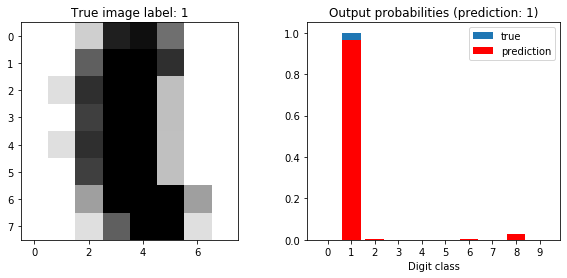

In [14]:
plot_prediction(lr, sample_idx=np.random.randint(0,X_test.shape[0]))

### b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

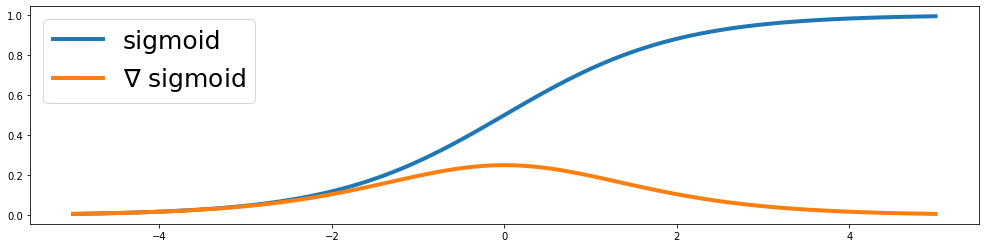

In [15]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    '''Return the derivative of the sigmoid.'''
    sig = sigmoid(X)
    return sig * (1 - sig)


x = np.linspace(-5, 5, 100)
plt.figure(figsize=(17,4))
plt.plot(x, sigmoid(x), lw=4, label='sigmoid')
plt.plot(x, dsigmoid(x), lw=4, label='$\\nabla$ sigmoid')
plt.legend(fontsize=25, loc='best')
plt.show()

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward` now has a keep activations parameter to also return hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

In [16]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), low=-0.01, high=0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), low=-0.01, high=0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        z_h = np.dot(X, self.W_h) + self.b_h
        h   = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y   = softmax(z_o)
        if keep_activations:
            return y, h, z_h
        else:
            return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y, h, z_h = self.forward(x, keep_activations=True)
        
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h   = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        
        grads    = {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [17]:
n_hidden = 30
model = NeuralNet(n_features, n_hidden, n_classes)

In [18]:
model.loss(X_train, y_train)

2.302471186017484

In [19]:
model.accuracy(X_train, y_train)

0.10096510764662213

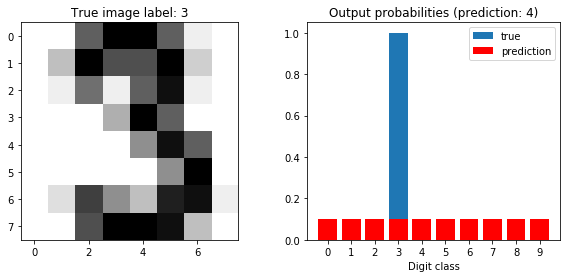

In [20]:
plot_prediction(model, sample_idx=np.random.randint(0,X_test.shape[0]))

In [21]:
N_epochs = 30

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30247, train acc: 0.101, test acc: 0.100
Epoch #1, train loss: 0.20294, train acc: 0.952, test acc: 0.949
Epoch #2, train loss: 0.08819, train acc: 0.980, test acc: 0.964
Epoch #3, train loss: 0.05501, train acc: 0.990, test acc: 0.971
Epoch #4, train loss: 0.03620, train acc: 0.996, test acc: 0.976
Epoch #5, train loss: 0.02733, train acc: 0.998, test acc: 0.973
Epoch #6, train loss: 0.02146, train acc: 0.999, test acc: 0.976
Epoch #7, train loss: 0.01728, train acc: 0.999, test acc: 0.976
Epoch #8, train loss: 0.01441, train acc: 0.999, test acc: 0.976
Epoch #9, train loss: 0.01229, train acc: 0.999, test acc: 0.973
Epoch #10, train loss: 0.01065, train acc: 0.999, test acc: 0.973
Epoch #11, train loss: 0.00932, train acc: 1.000, test acc: 0.973
Epoch #12, train loss: 0.00824, train acc: 1.000, test acc: 0.971
Epoch #13, train loss: 0.00735, train acc: 1.000, test acc: 0.969
Epoch #14, train loss: 0.00661, train acc: 1.000, test acc: 0.969
Epoch #15, train 

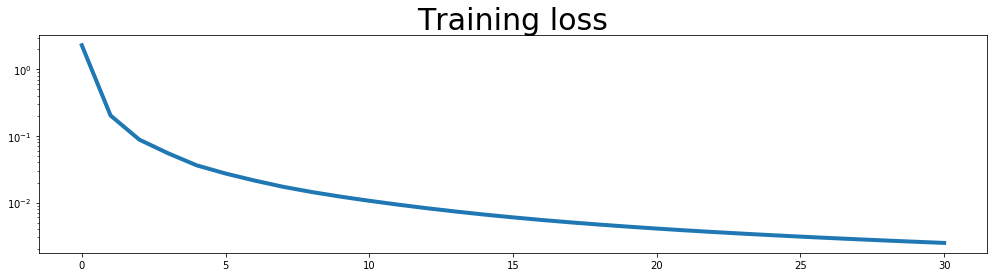

In [22]:
plt.figure(figsize=(17,4))
plt.semilogy(losses, lw=4)
plt.title("Training loss", fontsize=30)
plt.show()

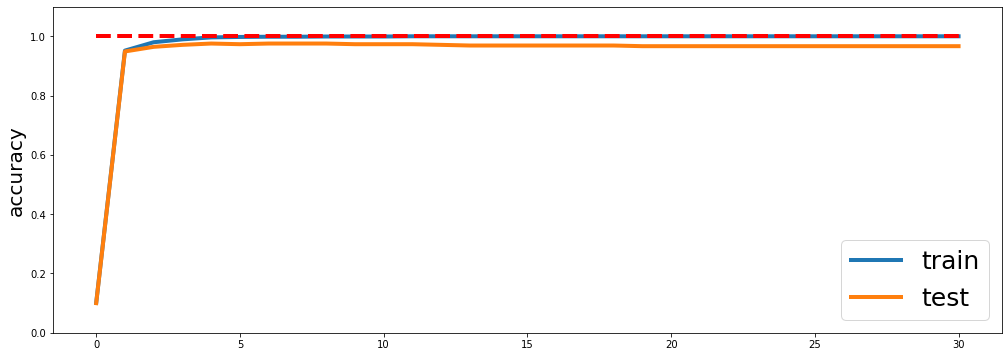

In [23]:
plt.figure(figsize=(17,6))
plt.plot(accuracies, lw=4, label='train')
plt.plot(accuracies_test, lw=4, label='test')
plt.plot((N_epochs+1)*[1], lw=4, ls='--', c='red')
plt.ylim(0, 1.1)
plt.ylabel("accuracy", fontsize=20)
plt.legend(fontsize=25, loc='best')
plt.show()

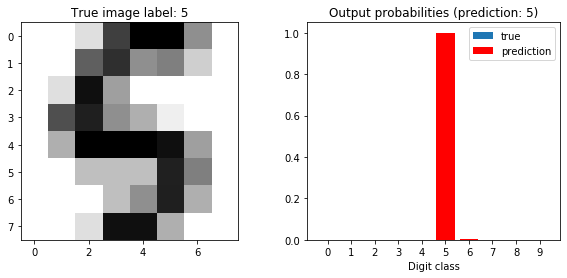

In [24]:
plot_prediction(model, sample_idx=np.random.randint(0,X_test.shape[0]))

### c) Play with the Network

#### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

test losses: [3.45597926 3.79213036 4.06126935 5.79479945 8.76378932]


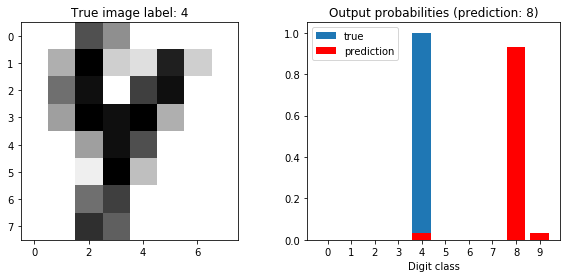

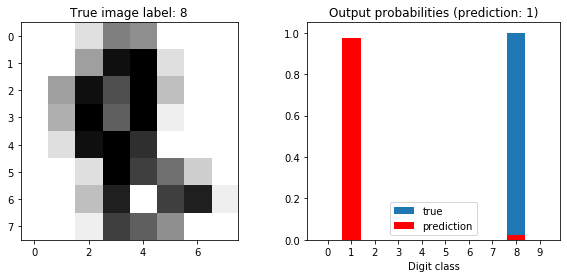

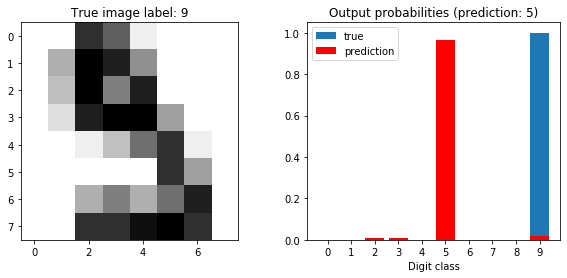

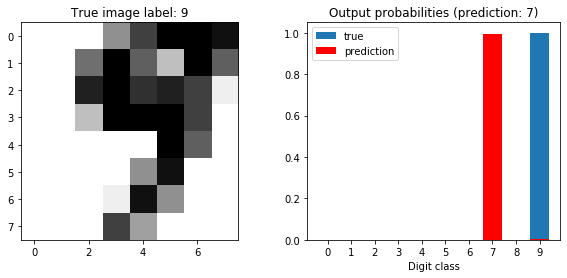

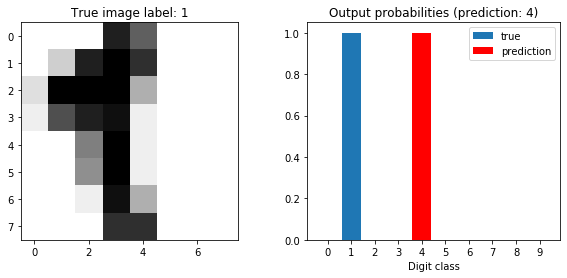

In [25]:
test_losses = -np.sum(np.log(EPSILON + model.forward(X_test)) * one_hot(10, y_test), axis=1)

# Sort by ascending loss: best predictions first, worst at the end
ranked_by_loss = test_losses.argsort()

# Extract and display the top 5 worst predictions at the end:
worst_idx = ranked_by_loss[-5:]
print("test losses:", test_losses[worst_idx])
for idx in worst_idx:
    plot_prediction(model, sample_idx=idx)

#### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


#### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of `K` samples at a time instead of one,
    - experiment with different sizes of batches.


#### Momentum

- Implement momentum

#### Play with https://playground.tensorflow.org